# 1- Import Libraries

In [1]:
!pip install kaggle

In [43]:
import os
import json
from zipfile import ZipFile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
import plotly.express as px
import re
import string
from tqdm.notebook import tqdm

import nltk
import spacy
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction import text
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras import regularizers
from tensorflow.keras.initializers import glorot_uniform

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 2- Load Data using Kaggle API

In [3]:
def load_data(path):
  """
  Load the IMDB dataset from Kaggle.

  Args:
    path (str): Path to the kaggle api credentials file.

  Returns:
    df: The IMDB dataset as a pandas DataFrame.
  """

  # Check if kaggle api credentials file exists
  if not os.path.exists(path):
    print("kaggle api credentials file not found")
    return

  # Load kaggle api credentials
  kaggle_dictionary = json.load(open(path))
  print(f"Kaggle Dictionary Keys are: {kaggle_dictionary.keys()} \n")

  # setup kaggle credentials as environment variables
  os.environ["KAGGLE_USERNAME"] = kaggle_dictionary["username"]
  os.environ["KAGGLE_KEY"] = kaggle_dictionary["key"]

  # Download the dataset
  print("Download the dataset from Kaggle:")
  !kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
  print("Dataset downloaded successfully")

  # Unzip the dataset file
  print("\nUnzip the dataset file:")
  with ZipFile("imdb-dataset-of-50k-movie-reviews.zip", "r") as zip_ref:
    zip_ref.extractall()
  print("Dataset unzipped successfully")

  # Read the dataset file
  print("\nRead the dataset file:")
  df = pd.read_csv("/content/IMDB Dataset.csv")
  print(f"Dataset shape: {df.shape}")
  print(f"Dataset columns: {df.columns}")
  print(f"Dataset head:\n{df.head()}")

  return df

In [4]:
df = load_data("kaggle.json")

Kaggle Dictionary Keys are: dict_keys(['username', 'key']) 

Download the dataset from Kaggle:
Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
 93% 24.0M/25.7M [00:00<00:00, 42.9MB/s]
100% 25.7M/25.7M [00:00<00:00, 45.5MB/s]
Dataset downloaded successfully

Unzip the dataset file:
Dataset unzipped successfully

Read the dataset file:
Dataset shape: (50000, 2)
Dataset columns: Index(['review', 'sentiment'], dtype='object')
Dataset head:
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


# 3- Clean Dataset

## Expand Contradictions in Text

In [5]:
def expand_contractions(text):
  """
  Expands contractions in a given text.

  Args:
    text (str): The text to expand contractions in.

  Returns:
    text (str): The text with expanded contractions.
  """

  # Define a dictionary of contractions
  contraction_mapping = {
    "he's": "he is",
    "we're": "we are",
    "they're": "they are",
    "it's": "it is",
    "i'm": "i am",
    "you're": "you are",
    "who's": "who is",
    "what's": "what is",
    "why's": "why is",
    "how's": "how is",
    "where's": "where is",
    "when's": "when is",
    "there's": "there is",
    "who're": "who are",
    "what're": "what are",
    "why're": "why are",
    "how're": "how are",
    "where're": "where are",
    "when're": "when are",
    "there're": "there are",
    "i've": "i have",
    "you've": "you have",
    "we've": "we have",
    "they've": "they have",
    "who've": "who have",
    "what've": "what have",
    "why've": "why have",
    "how've": "how have",
    "where've": "where have",
    "when've": "when have",
    "don't": "do not",
    "can't": "can not",
    "couldn't": "could not",
    "shouldn't": "should not",
    "wouldn't": "would not",
    "aren't": "are not",
    "isn't": "is not",
    "wasn't": "was not",
    "weren't": "were not",
    "haven't": "have not",
    "hasn't": "has not",
    "hadn't": "had not",
    "won't": "will not",
  }
  # Expand contractions
  for contraction, expansion in contraction_mapping.items():
    text = text.replace(contraction, expansion)
  return text


In [6]:
df_expand = df.copy()
df_expand['review'] = df_expand['review'].apply(lambda x:expand_contractions(x))
df_expand.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there is a family where a little boy...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Clean Text

In [7]:
def clean_text(text):
    '''
    This function is used to clean the text data.
    1. Lowercase the text
    2. Remove text in square brackets
    3. Remove HTML tags
    4. Remove special characters
    5. Remove links
    6. Remove extra whitespace
    7. Remove newline characters
    8. Remove words containing numbers
    9. Remove email

    Parameters:
    text (str): The text data to be cleaned.

    Returns:
    text (str): The cleaned text data.
    '''

    # Lowercase the text
    text = str(text).lower()
    # Remove text in square brackets
    text = re.sub('\[.*?\]', '', text)
    # Remove HTML tags
    text = re.sub('<.*?>', ' ', text)
    # Remove special characters
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    # Remove links
    text = re.sub('https?://\S+|www\.\S+', '', text)
    # Remove extra whitespace
    text = re.sub('\s+', ' ', text)
    # Remove newline characters
    text = re.sub('\n', '', text)
    # Remove words containing numbers
    text = re.sub('\w*\d\w*', '', text)
    # Remove email
    text = re.sub('\S*@\S*\s?', '', text)

    return text

In [8]:
df_cleaned = df_expand.copy()
df_cleaned['review'] = df_cleaned['review'].apply(lambda x:clean_text(x))
df_cleaned.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production the filming tech...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there is a family where a little boy...,negative
4,petter mattei s love in the time of money is a...,positive


## Remove Stopwords

In [11]:
# Stopwords list
stopwords_list = set(stopwords.words('english'))

def remove_stopwords(text):
    """
    Removes stopwords from a given text.

    Args:
        text (str): The text to remove stopwords from.

    Returns:
        str: The text without stopwords.
    """
    return " ".join([word for word in str(text).split() if word not in stopwords_list])

In [12]:
# Create a dataset without stopword
df_no_stopword = df_cleaned.copy()
df_no_stopword['review'] = df_no_stopword['review'].apply(lambda x:remove_stopwords(x))
df_no_stopword.head()

,review,sentiment
0,one reviewers mentioned watching oz episode ho...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically family little boy jake thinks zombie...,negative
4,petter mattei love time money visually stunnin...,positive


In [13]:
# Create a dataset with stopword and encode sentiment column. 'positive':1, 'negetive':0
df_stopword = df_cleaned.copy()
df_stopword['sentiment'] = df_stopword['sentiment'].map({'positive':1,'negative':0})

# Encode sentiment column for the dataset without stopwords
df_no_stopword['sentiment'] = df_no_stopword['sentiment'].map({'positive':1,'negative':0})
df_no_stopword.head()

,review,sentiment
0,one reviewers mentioned watching oz episode ho...,1
1,wonderful little production filming technique ...,1
2,thought wonderful way spend time hot summer we...,1
3,basically family little boy jake thinks zombie...,0
4,petter mattei love time money visually stunnin...,1


# 4- EDA

In [14]:
# Create a copy of the dataset without stopwords
df_EDA = df_no_stopword.copy()
df_EDA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


In [15]:
# Sentiment count in dataset
df_EDA['sentiment'].value_counts()

,count
sentiment,
1,25000
0,25000


## Number of Review Words

In [16]:
# Number of words in review
df_EDA['num_word'] = df_EDA['review'].apply(lambda x:len(str(x).split()))
df_EDA.head()

,review,sentiment,num_word
0,one reviewers mentioned watching oz episode ho...,1,164
1,wonderful little production filming technique ...,1,86
2,thought wonderful way spend time hot summer we...,1,84
3,basically family little boy jake thinks zombie...,0,64
4,petter mattei love time money visually stunnin...,1,125


In [17]:
# Sort number of words in review to demonstrate the maximum word number of reviews
df_EDA.sort_values('num_word',ascending=False).head()

,review,sentiment,num_word
31481,match tag team table match bubba ray spike dud...,1,1421
31436,back mid late oav anime title bubblegum crisis...,1,1154
31240,spoilers included although many commentators c...,1,1135
40521,sign lost highway says major spoilers ahead al...,1,1090
12647,titanic directed james cameron presents fictio...,1,924


In [18]:
# Create distplot
hist_data = [df_EDA['num_word']]
group_labels = ['Distribution_Plot']
fig = ff.create_distplot(hist_data, group_labels)
fig.update_layout(title_text='Distribution of Number of Words')
fig.update_layout(
    autosize=False,
    width=1000,
    height=600,
    paper_bgcolor="LightBlue",
    )
fig.show()

## Lemmatization

In [19]:
# Load the core English language model
sp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatizer_on_text(review):
  """
  Lemmatizes a given text.

  Args:
    review (str): The text to lemmatize.

  Returns:
    text (str): The lemmatized text.
  """
  # Lemmatize the text
  doc = sp(review)
  text = [token.lemma_ for token in doc]
  text = ' '.join(text)
  return text

In [20]:
df_EDA['review'] = df_EDA['review'].apply(lambda x:lemmatizer_on_text(x))
df_EDA.head()

,review,sentiment,num_word
0,one reviewer mention watch oz episode hook rig...,1,164
1,wonderful little production filming technique ...,1,86
2,think wonderful way spend time hot summer week...,1,84
3,basically family little boy jake think zombie ...,0,64
4,petter mattei love time money visually stunnin...,1,125


## Most Common Words of Reviews

In [21]:
def most_common_words(df, column_name='review', top_n=25, title='Common Words in Reviews'):
  """
  Finds the most common words in a given column of a DataFrame.

  Args:
    df: The pandas DataFrame.
    column_name: The name of the column to analyze.
    top_n: The number of most common words to return.
    title: The title of the plot.

  Returns:
    A pandas DataFrame with the most common words and their counts.
  """

  # Combine all reviews into a single string
  all_text = ' '.join(df[column_name].astype(str))

  # Split the text into words
  words = all_text.split()

  # Count the frequency of each word
  word_counts = Counter(words)

  # Get the top n most common words
  top_words = word_counts.most_common(top_n)

  # Create a DataFrame from the top words
  df_top_words = pd.DataFrame(top_words, columns=['Common_words', 'count'])
  print(df_top_words.head())

  # Create a bar chart
  figure_title = f'Top {top_n} {title}'
  fig = px.bar(df_top_words, x='count', y='Common_words',
             title= figure_title, color='Common_words',
             labels={'Common_words':'Common Words'}, orientation='h')

  fig.update_layout(
    autosize=False,
    width=1000,
    height=600,
    paper_bgcolor="LightBlue",
    )
  fig.show()

  return df_top_words

In [22]:
df_top_words = most_common_words(df_EDA)

  Common_words   count
0        movie  103216
1         film   95638
2          one   55439
3          see   47516
4         make   45756


In [23]:
df_top_words_positive = most_common_words(df_EDA[df_EDA['sentiment']==1], title='Common Words in Positive Sentiment Reviews')

  Common_words  count
0         film  50757
1        movie  44807
2          one  28283
3          see  25144
4         good  21984


In [24]:
df_top_words_negative = most_common_words(df_EDA[df_EDA['sentiment']==0], title='Common Words in Negative Sentiment Reviews')

  Common_words  count
0        movie  58409
1         film  44881
2          one  27156
3         make  24768
4         like  24181


## Word Cloud

In [25]:
def add_stop_words(df, column_name='review'):
  """
  Adds additional stop words to a given column of a DataFrame.

  Args:
    df: The pandas DataFrame.
    column_name: The name of the column to analyze.

  Returns:
    A list of additional stop words.
  """
  # Combine all reviews into a single string
  all_text = ' '.join(df[column_name].astype(str))

  # Split the text into words
  words = all_text.split()
  add_stop_words = [word for word, count in Counter(words).most_common() if count > 3000]

  # Add new stop words
  stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

  return add_stop_words

In [26]:
add_stopwords = add_stop_words(df_EDA)

In [27]:
def plot_wordcloud(df, add_stopwords):
  """
  Plots word clouds for positive and negative sentiments in one figure.

  Args:
    df: The pandas DataFrame containing the reviews and sentiments.
    add_stopwords: A list of additional stop words to exclude.
  """

  wc = WordCloud(stopwords=add_stopwords, background_color="white", colormap="Dark2",
                 max_font_size=150, random_state=42)

  plt.rcParams['figure.figsize'] = [16, 6]

  # Create subplots for positive and negative sentiments
  plt.subplot(1, 2, 1)
  wc.generate(' '.join(df[df['sentiment'] == 1]['review']))
  plt.imshow(wc, interpolation="bilinear")
  plt.axis("off")
  plt.title("Positive Sentiment")

  plt.subplot(1, 2, 2)
  wc.generate(' '.join(df[df['sentiment'] == 0]['review']))
  plt.imshow(wc, interpolation="bilinear")
  plt.axis("off")
  plt.title("Negative Sentiment")

  plt.show()

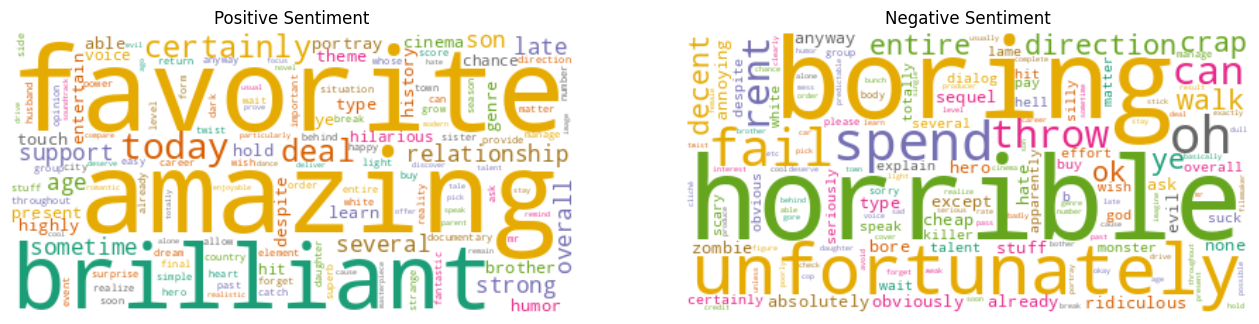

In [28]:
plot_wordcloud(df_EDA, add_stopwords)

# 5- Split Data to Train, Validation, and Test

In [29]:
def split_data(df, test_size=0.1, random_state=56):

  """
  Splits a given DataFrame into training, and test sets.

  Args:
    df: The pandas DataFrame to split.
    test_size: The size of the test set.
    random_state: The random seed for reproducibility.

  Returns:
    train_data: The training set.
    test_data: The test set.
  """

  # Split the data into positive and negative sentiment
  df_positve_sentiment = df[df['sentiment']==1]
  df_negative_sentiment = df[df['sentiment']==0]

  # Split the positive sentiment data into training, validation, and test sets
  train_positive, test_positive = train_test_split(df_positve_sentiment, test_size=test_size, random_state=random_state)

  # Split the negative sentiment data into training, validation, and test sets
  train_negative, test_negative = train_test_split(df_negative_sentiment, test_size=test_size, random_state=random_state)

  # Concatenate and shuffle the training, validation, and test sets
  train_temp = pd.concat([train_positive, train_negative])
  train_data = train_temp.sample(frac=1).reset_index(drop=True)

  test_temp = pd.concat([test_positive, test_negative])
  test_data = test_temp.sample(frac=1).reset_index(drop=True)

  return train_data, test_data

In [30]:
train_data, test_data = split_data(df_stopword)
print("Train Data:\n", train_data['sentiment'].value_counts())
print("\nTest Data:\n", test_data['sentiment'].value_counts())

Train Data:
 sentiment
0    22500
1    22500
Name: count, dtype: int64

Test Data:
 sentiment
0    2500
1    2500
Name: count, dtype: int64


# 6- Preprocessing Data

In [31]:
def preprocessing_data(train_data, test_data):
  """
  Preprocesses the data for the model.

  Args:
    train_data: The training data.
    test_data: The test data.

  Returns:
    X_train: The training data.
    X_test: The test data.
    Y_train: The training labels.
    Y_test: The test labels.
  """

  tokenizer = Tokenizer(oov_token='<OOV>', num_words=7000)

  # Tokenize training data
  tokenizer.fit_on_texts(train_data["review"])
  X_train = pad_sequences(tokenizer.texts_to_sequences(train_data["review"]), padding='post', truncating='post', maxlen=600)
  Y_train = train_data["sentiment"]

  # Tokenize test data
  X_test = pad_sequences(tokenizer.texts_to_sequences(test_data["review"]), padding='post', truncating='post', maxlen=600)
  Y_test = test_data["sentiment"]

  return X_train, X_test, Y_train, Y_test

In [32]:
X_train, X_test, Y_train, Y_test = preprocessing_data(train_data, test_data)

print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)

print("\nX_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (45000, 600)
Y_train shape: (45000,)

X_test shape: (5000, 600)
Y_test shape: (5000,)


# 6- LSTM based Model

## Create Model

In [33]:
def create_model(input_shape):
  """
  Creates an LSTM model.

  Args:
    input_shape: The shape of the input data.

  Returns:
    model: The LSTM model.
  """
  inputs = Input((input_shape, ), dtype='int32')
  embedding_layer = Embedding(input_dim=7000, output_dim=128)(inputs)
  conv_layer1 = Conv1D(32, 7, activation='relu', padding = 'same')(embedding_layer)
  maxpooling_layer1 = MaxPooling1D(5)(conv_layer1)
  lstm_layer_1 = Bidirectional(LSTM(units=64, dropout=0.4, recurrent_dropout=0.4, kernel_regularizer=regularizers.l2(0.001), return_sequences=True))(maxpooling_layer1)
  lstm_layer_2 = Bidirectional(LSTM(units=64, dropout=0.4, recurrent_dropout=0.4, kernel_regularizer=regularizers.l2(0.001)))(lstm_layer_1)
  outputs = Dense(units=1, activation='sigmoid')(lstm_layer_2)

  model = Model(inputs=inputs, outputs=outputs)

  return model

In [34]:
model = create_model(X_train.shape[1])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 600)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 600, 128)            │         896,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 600, 32)             │          28,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 120, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 120, 128)            │          49,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,073,313 (4.09 MB)

 Trainable params: 1,073,313 (4.09 MB)

 Non-trainable params: 0 (0.00 B)

## Train Model

In [35]:
# Set hyperparameters for training
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

In [36]:
model.fit(X_train, Y_train, epochs = 3, batch_size = 128, validation_split = 0.2, shuffle=True)

Epoch 1/3
282/282 ━━━━━━━━━━━━━━━━━━━━ 278s 923ms/step - accuracy: 0.6734 - loss: 0.7427 - val_accuracy: 0.8761 - val_loss: 0.3383
Epoch 2/3
282/282 ━━━━━━━━━━━━━━━━━━━━ 288s 834ms/step - accuracy: 0.8818 - loss: 0.3275 - val_accuracy: 0.8811 - val_loss: 0.3236
Epoch 3/3
282/282 ━━━━━━━━━━━━━━━━━━━━ 260s 825ms/step - accuracy: 0.8926 - loss: 0.2967 - val_accuracy: 0.8836 - val_loss: 0.3130


## Test Data Evaluation

In [37]:
# Evaluate test dataset
loss, accuracy = model.evaluate(X_test, Y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 29s 184ms/step - accuracy: 0.8920 - loss: 0.3002
Test Loss: 0.3039916157722473
Test Accuracy: 0.8895999789237976


# 8- Hugging Face Model

## Import from Hugging Face

In [38]:
from transformers import AutoTokenizer, AutoModelWithLMHead

## T5 Base Finetuned Model and Tokenizer

In [39]:
# Set up HuggingFace tokenizer and model
MODEL_NAME = "mrm8488/t5-base-finetuned-imdb-sentiment"
T5_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, model_max_length=512)
T5_sentiment_model = AutoModelWithLMHead.from_pretrained(MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.10/dist-packages/transformers/models/auto/modeling_auto.py:1731: FutureWarning:

The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.



model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

## Truncate Reviews

In [40]:
def truncate_reviews(df, column_name='review', max_length=512):
  """
  Truncates reviews in a DataFrame to a maximum length to fit into the model.

  Args:
    df: The pandas DataFrame containing the reviews.
    column_name: The name of the column containing the reviews.
    max_length: The maximum length of the reviews after truncation.

  Returns:
    The DataFrame with truncated reviews.
  """

  # Truncate reviews to fit to the LLM
  df[column_name] = df[column_name].apply(lambda text: text[:max_length] if len(text) > max_length else text)
  return df

In [41]:
df_hug = test_data.copy()
df_hug = truncate_reviews(df_hug)
df_hug.head()

,review,sentiment
0,well this movie was not as horrible as i thoug...,0
1,there is one detail which is not very common f...,1
2,how nice to have a movie the entire family can...,1
3,most people gave this movie a and those who ...,1
4,the basic hook here is lincoln is slow it is h...,1


## Test Data Evaluation with T5 Base Finetuned Model

In [42]:
def get_sentiment(text):
  """
  Gets the sentiment of a given text.

  Args:
    text: The text to get the sentiment of.

  Returns:
    The sentiment of the text.
  """

  # Tokenize text
  input_ids = T5_tokenizer.encode(text + '</s>', return_tensors='pt')

  # Generate sentiment
  output = T5_sentiment_model.generate(input_ids=input_ids, max_length=2)

  # Decode sentiment
  dec = [T5_tokenizer.decode(ids, skip_special_tokens=True) for ids in output]
  label = dec[0]
  if label == 'positive':
    return 1
  else:
    return 0

In [44]:
tqdm.pandas()

df_hug['sentiment_predict'] = df_hug['review'].progress_apply(lambda x:get_sentiment(x))
df_hug.head()

  0%|          | 0/5000 [00:00<?, ?it/s]

,review,sentiment,sentiment_predict
0,well this movie was not as horrible as i thoug...,0,0
1,there is one detail which is not very common f...,1,1
2,how nice to have a movie the entire family can...,1,1
3,most people gave this movie a and those who ...,1,1
4,the basic hook here is lincoln is slow it is h...,1,1


## Evaluation Metrics

In [48]:
def evaluate_sentiment(y_true, y_pred):
  """
  Calculates accuracy and plots confusion matrix.

  Args:
    y_true: True sentiment labels.
    y_pred: Predicted sentiment labels.
  """

  # Calculate accuracy
  accuracy = accuracy_score(y_true, y_pred)
  print(f"Accuracy for sentiment prediction of fine-tuned T5 model: {accuracy} \n\n")

  # Plot confusion matrix
  cm = confusion_matrix(y_true, y_pred)
  plt.figure(figsize=(6, 4))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
              xticklabels=['Negative', 'Positive'],
              yticklabels=['Negative', 'Positive'])
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix')
  plt.show()

Accuracy for sentiment prediction of fine-tuned T5 model: 0.9048 




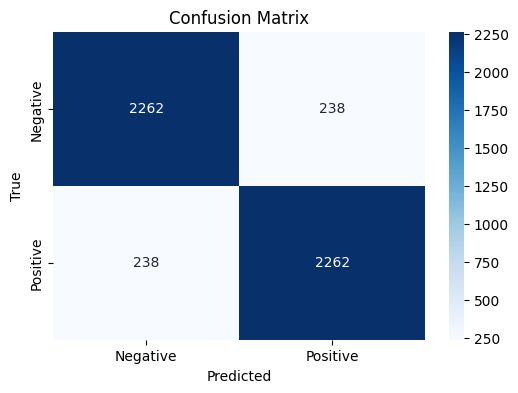

In [49]:
# Evaluate test data using finetuned T5 model
evaluate_sentiment(df_hug['sentiment'], df_hug['sentiment_predict'])